In [34]:
import treeswift
import subprocess
import dendropy
import treedata
import networkx
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%reload_ext autoreload
%autoreload 2

from helpers.utils import build_summary_df, plot_genotype_confidence, clustermap_genos
from helpers.utils import report_genotype_call_stats, save_df_to_pdf, plot_correlation, branch_table, plot_bl_variance, add_internal_labels
from helpers.utils import plot_tree_3d, edge_ratio_table
from helpers.utils import distdict_to_df, leaf_pairs, get_geno_dict, plot_state_counts

### Experiment 1

Comparing LAML-Pro (695 cells) to PETracer (695 cells).

In [4]:
colony = 3

In [6]:
plotdir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/exp2"

In [7]:
binary_pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_subset/clone3.petracer.neighbor_joining.binary.nwk'
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.newick"

In [8]:
pet_tree = treeswift.read_tree_newick(binary_pet_tree_fname)
lp_tree = treeswift.read_tree_newick(lp_tree_fname)

In [9]:
lp_tree.height(), pet_tree.height()

(1.0850950000000001, 6.000000000912237)

In [12]:
pet_leaves = set([n.label for n in pet_tree.traverse_leaves()])
lp_leaves = set([n.label for n in lp_tree.traverse_leaves()])
len(pet_leaves), len(lp_leaves)

(695, 832)

In [13]:
lp_tree = lp_tree.extract_tree_with(pet_leaves)

/Users/gc3045/miniconda3/lib/python3.13/site-packages/treeswift/Tree.py:1187: UserWarning: Deleting a node with label/attributes in suppress_unifurcations: internal_859
  warn("Deleting a node with label/attributes in suppress_unifurcations: %s" % tmp_s)
/Users/gc3045/miniconda3/lib/python3.13/site-packages/treeswift/Tree.py:1187: UserWarning: Deleting a node with label/attributes in suppress_unifurcations: internal_849
  warn("Deleting a node with label/attributes in suppress_unifurcations: %s" % tmp_s)
/Users/gc3045/miniconda3/lib/python3.13/site-packages/treeswift/Tree.py:1187: UserWarning: Deleting a node with label/attributes in suppress_unifurcations: internal_858
  warn("Deleting a node with label/attributes in suppress_unifurcations: %s" % tmp_s)
/Users/gc3045/miniconda3/lib/python3.13/site-packages/treeswift/Tree.py:1187: UserWarning: Deleting a node with label/attributes in suppress_unifurcations: internal_1355
  warn("Deleting a node with label/attributes in suppress_unifurc

In [14]:
lp_leaves = set([n.label for n in lp_tree.traverse_leaves()])
len(pet_leaves), len(lp_leaves)

(695, 695)

In [16]:
new_lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.subset.newick"
lp_tree.write_tree_newick(new_lp_tree_fname)

In [17]:
# robinson-foulds
output = subprocess.run(["python", "/Users/gc3045/git/fast-laml/scripts/compare_two_trees.py",
                         "-t1", binary_pet_tree_fname,
                         "-t2", new_lp_tree_fname])
print("Robinson-Foulds distance between published PEtracer tree and LAML-Pro tree:", output)

695,692,692,642,642,0.927746
Robinson-Foulds distance between published PEtracer tree and LAML-Pro tree: CompletedProcess(args=['python', '/Users/gc3045/git/fast-laml/scripts/compare_two_trees.py', '-t1', '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_subset/clone3.petracer.neighbor_joining.binary.nwk', '-t2', '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.subset.newick'], returncode=0)


In [18]:
pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_clone3.petracer.neighbor_joining.nwk'

In [19]:
colony_petracer_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/28473866/colony_tracing.h5ad"
colony_pet_df = treedata.read_h5ad(colony_petracer_fname)

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_51703/880964046.py:2: DeprecationWarning: read_h5ad has been renamed to read_h5td. read_h5ad will be removed in v1.0.0.
  colony_pet_df = treedata.read_h5ad(colony_petracer_fname)


In [23]:
mask = [x in lp_leaves for x in colony_pet_df.obs['cellBC']]
meta_df = colony_pet_df.obs.loc[mask]
# meta_df = meta_df.loc[(meta_df['colony'] == '3') & (meta_df['type'] == 'tracing') & (meta_df['detection_rate'] > 0.5999)]

In [24]:
colony = 3

In [25]:
# take only the cells in the published tree
centroids_df = meta_df[['centroid_x', 'centroid_y']]
centroids_subset_df = centroids_df.loc[[x for x in centroids_df.index if x in pet_leaves]]

# centroids_subset_df.to_csv('/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/colonies_clone3_centroids_subset.txt', 
#                     sep="\t",
#                     header=None)

In [26]:
centroids_subset_df.var(axis=0), centroids_subset_df.shape

(centroid_x    20818.082991
 centroid_y    24035.037857
 dtype: float64,
 (695, 2))

In [27]:
var_x, var_y = centroids_subset_df.var(axis=0)
print("Variance", var_x, var_y)

Variance 20818.082991463172 24035.037857028718


#### Scale both trees to 6 days.

In [53]:
tau = 6

In [54]:
pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_clone3.petracer.neighbor_joining.nwk'
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.subset.newick"
pet_tree = treeswift.read_tree_newick(pet_tree_fname)
lp_tree = treeswift.read_tree_newick(lp_tree_fname)

In [55]:
pet_leaves = set([n.label for n in pet_tree.traverse_leaves()])
lp_leaves = set([n.label for n in lp_tree.traverse_leaves()])
len(pet_leaves), len(lp_leaves)

(695, 695)

In [56]:
branch_thresh = 0.00005
print(sum([n.get_edge_length() < branch_thresh for n in lp_tree.traverse_postorder()]))
lp_tree.collapse_short_branches(branch_thresh)

86


In [57]:
print(pet_tree.root.get_edge_length()) # the root branch is None
print(lp_tree.root.get_edge_length()) # the root branch is not None
lp_tree.root.set_edge_length(0.0)

pet_tree.scale_edges(tau/pet_tree.height())
lp_tree.scale_edges(tau/lp_tree.height())
# pet_tree.root.children, lp_tree.root.children

None
0.016005


Text(0.5, 1.0, 'LAML-Pro branch lengths')

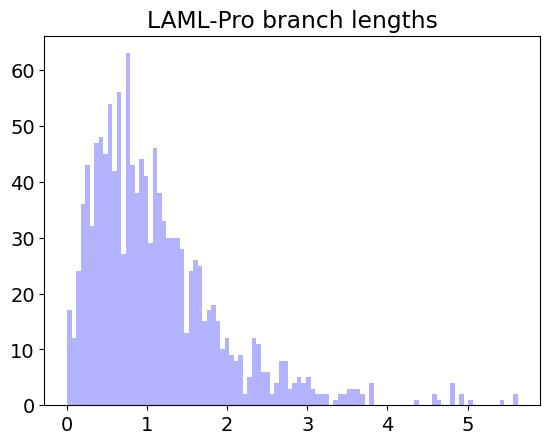

In [58]:
lp_branches = [branch.get_edge_length() for branch in lp_tree.traverse_postorder()]

plt.hist(lp_branches, bins=100, color='blue', alpha=0.3)
plt.title("LAML-Pro branch lengths")

Text(0.5, 1.0, 'PETracer branch lengths')

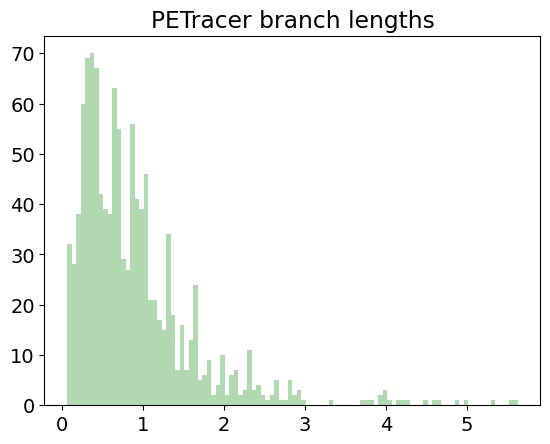

In [59]:

pet_branches = [branch.get_edge_length() for branch in pet_tree.traverse_postorder() if branch.get_edge_length() is not None]
plt.hist(pet_branches, bins=100, color='green', alpha=0.3)
plt.title("PETracer branch lengths")

In [60]:
polytomies = 0
polytomy_depth = []
for node in pet_tree.traverse_postorder():
    if node.is_leaf():
        continue
    else:
        if len(node.children) >= 2:
            polytomies += 1
            polytomy_depth.append(pet_tree.distance_between(node, pet_tree.root))
            print([child.get_edge_length() for child in node.children])

[1.0546753481910855, 1.0546753484905722]
[1.1912621341780403, 1.191262134727742, 1.191262134941807]
[0.9376758337630106, 1.9923511823915256, 0.8010890474360886, 1.9923511823468734]
[0.7180591448223593, 2.7104103271865956]
[2.668911717221069, 2.668911717221069]
[0.2965930360001961, 0.3380916459270127]
[0.4506901144541484, 0.45069011516407564]
[1.7130940926414733, 2.163784207977724]
[0.060000081732330825, 0.060000081732330825]
[1.3920445037393252, 1.3920445033428805, 1.3320444218149958, 1.3920445035783313]
[0.9293333254068785, 0.9293333248520033]
[1.6507977703620125, 0.7214644450614311, 1.650797770441563]
[0.6823557574367752, 0.42360249077800394]
[1.019789163399916, 1.0197891633840994]
[1.4666059672059852, 0.4468168037726799, 1.4666059671159]
[0.5987195404226492, 2.762503748271145, 0.688103487097321, 1.2958977809640815]
[0.3963462678106876, 0.39634626731277567]
[0.5861980600711669, 0.9825443277788455, 0.9825443277789254]
[1.125511683940408, 2.108056011994326]
[0.3206603249868633, 0.97510

456


Text(0.5, 1.0, 'PETracer polytomy depth')

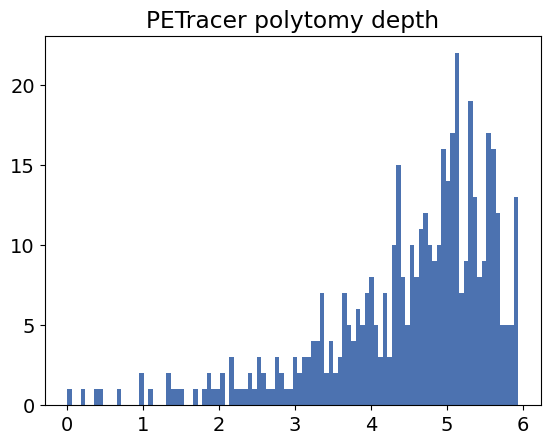

In [61]:
pet_polytomies = polytomies
print(pet_polytomies)
plt.hist(polytomy_depth, bins=100)
plt.title("PETracer polytomy depth")

In [62]:
polytomies = 0
polytomy_depth = []

for node in lp_tree.traverse_postorder():
    if node.is_leaf():
        continue
    else:
        if len(node.children) >= 2:
            polytomies += 1
            polytomy_depth.append(pet_tree.distance_between(node, lp_tree.root))
            print([child.get_edge_length() for child in node.children])

[3.032823272898701, 3.032823272898701]
[3.452513308059478, 3.452513308059478]
[2.0636092972615, 2.0636092972615]
[0.9783844001762247, 3.0419936974377246]
[3.6848326004663776, 3.684826988211458, 0.6428332907737334]
[4.6420195138103555, 0.9571869133439778]
[1.877933455493415, 1.4582321958227984, 0.268725990071921]
[0.1298844156099258, 5.040635531747122]
[0.3834741541630303, 5.424109685910152]
[0.20405036437565063, 5.628154438030882, 5.628154438030884]
[0.8601061277405341, 0.8601061277405341]
[0.5401121889758476, 1.4002183167163815]
[0.40658541992294367, 1.8068037366393253]
[1.986872935742487, 0.18006919910316163]
[4.806183582470682, 2.8193106467281948]
[2.19370136630346, 2.19370136630346]
[0.09015526303235744, 2.7026430914544997]
[1.8274456102345076, 1.8274456102345076]
[0.6955716502554978, 2.5230172604900054]
[1.1246397633873324, 1.1246397633873324]
[1.6368702699214, 0.5122192820242281, 1.6368590454115601]
[0.5793923611598285, 1.4655393517284339]
[1.0166936522590728, 1.0166936522590728]

610


Text(0.5, 1.0, 'LAML-Pro polytomy depth')

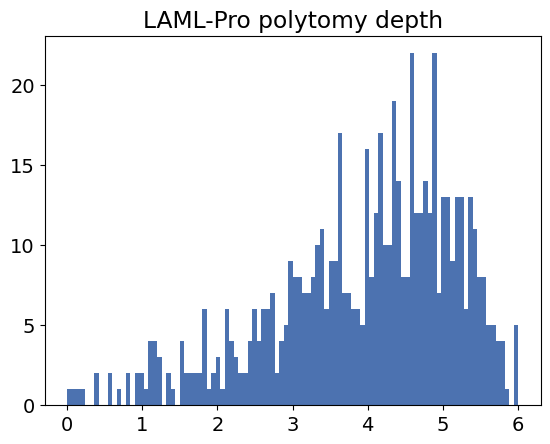

In [63]:

lp_polytomies = polytomies
print(lp_polytomies)
plt.hist(polytomy_depth, bins=100)
plt.title("LAML-Pro polytomy depth")

In [39]:
min(pet_branches), min(lp_branches)

(0.0600000013425781, 1e-06)

In [40]:
1e-6 * 22426.560424245945

0.022426560424245946

In [41]:
0.06 * 22426.560424245945

1345.5936254547566

In [42]:
diffusion_scale = (var_x + var_y)/(2*tau)
print("diffusion_scale", diffusion_scale)

diffusion_scale 3737.7600707076576


In [45]:
pet_tree.scale_edges(diffusion_scale)
lp_tree.scale_edges(diffusion_scale)
print("Tree heights", pet_tree.height(), lp_tree.height())

Tree heights 22426.560424245945 22426.560424245945


In [46]:
add_internal_labels(pet_tree)
add_internal_labels(lp_tree)
# pet_tree.is_rooted, lp_tree.is_rooted
pet_tree.is_rooted = False

In [47]:
pet_tree.write_tree_newick(pet_tree_fname[:-4] + ".scaled.newick")
lp_tree.write_tree_newick(lp_tree_fname[:-7] + ".scaled.newick")

In [48]:
pet_tree_fname[:-4] + ".scaled.newick", lp_tree_fname[:-7] + ".scaled.newick"

('/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_clone3.petracer.neighbor_joining.scaled.newick',
 '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.subset.scaled.newick')

In [ ]:
pet_tree.

#### Compute spatial correlation

In [65]:
lp_tree_fname

'/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.subset.newick'

In [66]:
lp_tree = treeswift.read_tree_newick(lp_tree_fname) #[:-7] + ".scaled.newick")
pet_tree = treeswift.read_tree_newick(pet_tree_fname) #[:-4] + ".scaled.newick")

In [67]:
lp_tree.height(), pet_tree.height()

(1.0850950000000001, 6.000000000912237)

In [68]:
pet_tree.scale_edges(6/pet_tree.height())
lp_tree.scale_edges(6/lp_tree.height())

In [70]:
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))
pet_distmat = distdict_to_df(pet_tree.distance_matrix(leaf_labels=True))

In [71]:
# sample down to 500, and compute over 10 iterations the pearson correlation between centroids_df and lp vs. centroids_df and pet

In [72]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

def subsample_spatial_correlations(
    centroids_df: pd.DataFrame,
    pet_distmat: pd.DataFrame,
    lp_distmat: pd.DataFrame,
    n_samples: int = 500,
    n_iters: int = 10,
    dist_scale: float = 0.5,      # if your PET/LP are "leaf-pair" distances, divide by 2
    random_state: int = 0,
):
    """
    centroids_df: index = cell IDs (e.g., 'colony-21229'), columns ['centroid_x','centroid_y']
    pet_distmat, lp_distmat: square DataFrames with same kind of IDs on both axes
    n_samples: number of cells to draw per iteration (will cap at available)
    n_iters: number of subsampling iterations
    dist_scale: multiply PET/LP distances by this factor before correlation
    """
    # Ensure indices align across all three objects
    ids = (
        set(centroids_df.index)
        & set(pet_distmat.index) & set(pet_distmat.columns)
        & set(lp_distmat.index)  & set(lp_distmat.columns)
    )
    ids = pd.Index(sorted(ids))
    if len(ids) < 3:
        raise ValueError("Fewer than 3 overlapping cells across centroids/PET/LP. Need at least 3.")

    # Restrict to common IDs (and reorder matrices symmetrically)
    C = centroids_df.loc[ids, ["centroid_x", "centroid_y"]]
    PET = pet_distmat.loc[ids, ids].astype(float) * dist_scale
    LP  = lp_distmat.loc[ids, ids].astype(float) * dist_scale

    # Precompute RNG
    rng = np.random.default_rng(random_state)

    # Helper to get upper-triangle vector (excluding diagonal)
    def upper_tri_vec(M: np.ndarray):
        iu = np.triu_indices(M.shape[0], k=1)
        return M[iu]

    # Run subsampling
    records = []
    n_available = len(ids)
    n = min(n_samples, n_available)

    for it in range(1, n_iters + 1):
        # Sample without replacement
        chosen = rng.choice(ids, size=n, replace=False)
        # Centroid distances on subset
        XY = C.loc[chosen].values
        D_centroid = squareform(pdist(XY, metric="euclidean"))

        # PET / LP submatrices (match ordering of 'chosen')
        PET_sub = PET.loc[chosen, chosen].values
        LP_sub  = LP.loc[chosen, chosen].values

        # Flatten upper triangles
        v_cent  = upper_tri_vec(D_centroid)
        v_pet   = upper_tri_vec(PET_sub)
        v_lp    = upper_tri_vec(LP_sub)

        # Guard: if all-zero variance, pearsonr fails
        def safe_pearsonr(a, b):
            if np.std(a) == 0 or np.std(b) == 0:
                return np.nan, np.nan
            r, p = pearsonr(a, b)
            return float(r), float(p)

        r_pet, p_pet = safe_pearsonr(v_cent, v_pet)
        r_lp,  p_lp  = safe_pearsonr(v_cent, v_lp)

        records.append({
            "iter": it,
            "n_cells": int(n),
            "pearson_r_centroid_vs_PET": r_pet,
            "pval_centroid_vs_PET": p_pet,
            "pearson_r_centroid_vs_LP": r_lp,
            "pval_centroid_vs_LP": p_lp,
        })

    results = pd.DataFrame.from_records(records)

    # Quick summary (mean ± std across iterations)
    summary = (
        results.drop(columns=["iter", "n_cells"])
        .agg(["mean", "std", "min", "max"])
        .round(6)
    )

    return results, summary

# ---- example usage ----
# results_df, summary_df = subsample_spatial_correlations(
#     centroids_df, pet_distmat, lp_distmat,
#     n_samples=500, n_iters=10, dist_scale=0.5, random_state=42
# )
# print(summary_df)
# results_df.to_csv(f"{plotdir}/colony_{colony}_subsample_corrs.csv", index=False)


In [73]:
results_df, summary_df = subsample_spatial_correlations(
    centroids_df, pet_distmat, lp_distmat,
    n_samples=50, n_iters=10, dist_scale=0.5, random_state=42
)

In [74]:
results_df

,iter,n_cells,pearson_r_centroid_vs_PET,pval_centroid_vs_PET,pearson_r_centroid_vs_LP,pval_centroid_vs_LP
0,1,50,0.022592,0.429520,0.072452,1.119514e-02
1,2,50,-0.092544,0.001184,-0.005814,8.389003e-01
2,3,50,-0.012530,0.661299,0.065091,2.270948e-02
3,4,50,-0.008316,0.771222,0.085927,2.612998e-03
4,5,50,0.122951,0.000016,0.169661,2.294826e-09
5,6,50,-0.051569,0.071189,0.101392,3.790267e-04
6,7,50,0.016294,0.568848,0.085541,2.732139e-03
7,8,50,0.073384,0.010191,0.115029,5.453373e-05
8,9,50,0.009871,0.729980,0.081674,4.230397e-03
9,10,50,-0.021354,0.455245,0.058658,4.010064e-02


In [75]:
results_df.mean()

iter                          5.500000
n_cells                      50.000000
pearson_r_centroid_vs_PET     0.005878
pval_centroid_vs_PET          0.369869
pearson_r_centroid_vs_LP      0.082961
pval_centroid_vs_LP           0.092291
dtype: float64

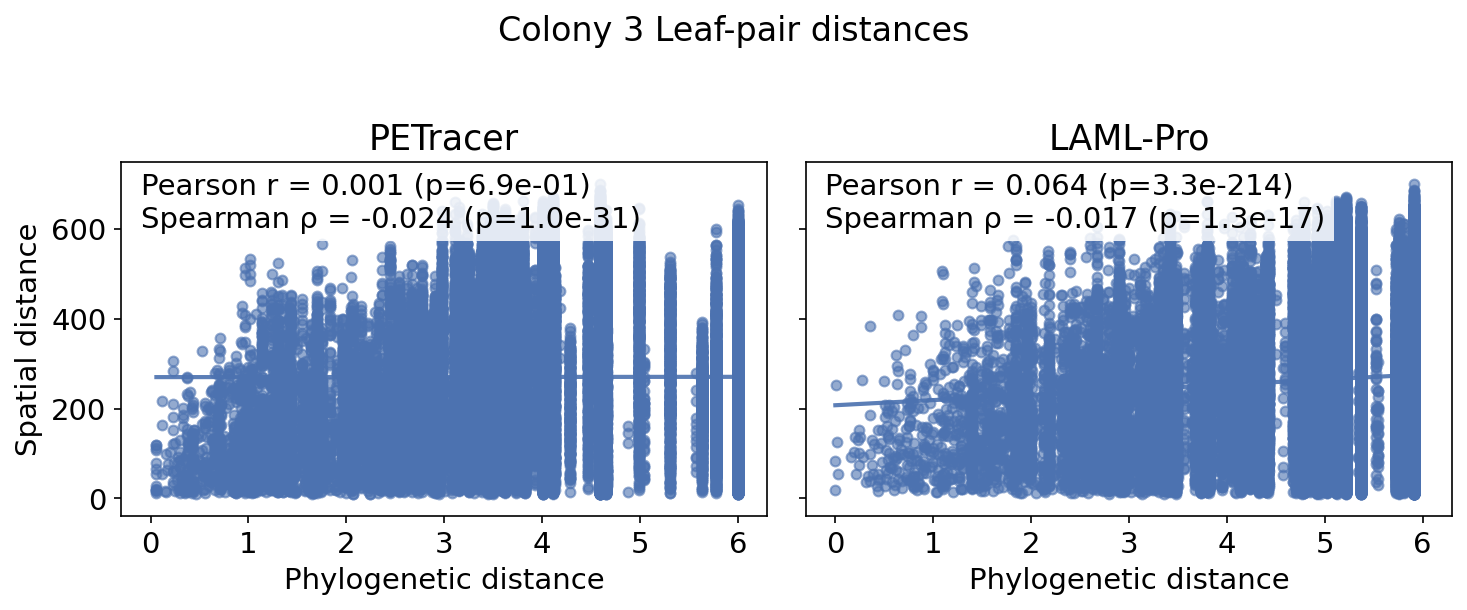

(<Figure size 1500x600 with 2 Axes>,
 array([<Axes: title={'center': 'PETracer'}, xlabel='Phylogenetic distance', ylabel='Spatial distance'>,
        <Axes: title={'center': 'LAML-Pro'}, xlabel='Phylogenetic distance'>],
       dtype=object))

In [76]:
plot_correlation(centroids_df, pet_distmat/2, lp_distmat/2, title=f"Colony {colony} Leaf-pair distances", titles=["PETracer", "LAML-Pro"],
                outfile=f"{plotdir}/colonies_colony{colony}_exp2_spatial_correlation.pdf")

In [95]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# ---------- helpers unchanged except for concise bin labels ----------
def _upper_tri_pairs(index):
    n = len(index)
    iu = np.triu_indices(n, k=1)
    return pd.DataFrame({"obs1": index.values[iu[0]],
                         "obs2": index.values[iu[1]],
                         "i": iu[0], "j": iu[1]})

def _short_binlabel(cat):
    if pd.isna(cat):
        return "All"
    # cat is a pandas Interval
    a = f"{cat.left:.3f}".rstrip("0").rstrip(".")
    b = f"{cat.right:.1f}".rstrip("0").rstrip(".")
    return f"[{a}–{b})"

def _prep_long_df(centroids_df, distmat, dist_scale=0.5, detection_rate=None,
                  detection_bin_edges=None, tree_bin_edges=None):
    ids = centroids_df.index.intersection(distmat.index).intersection(distmat.columns)
    if len(ids) < 3:
        raise ValueError("Need ≥3 overlapping cells across centroids and dist matrix.")
    C = centroids_df.loc[ids, ["centroid_x", "centroid_y"]].astype(float)
    D_tree = distmat.loc[ids, ids].astype(float).values * float(dist_scale)

    XY = C.values
    D_spatial = squareform(pdist(XY, metric="euclidean"))

    pairs = _upper_tri_pairs(C.index)
    pairs["spatial_distances"] = D_spatial[pairs["i"], pairs["j"]]
    pairs["tree_distances"]    = D_tree[pairs["i"], pairs["j"]]

    if detection_rate is not None:
        if isinstance(detection_rate, pd.DataFrame):
            if detection_rate.shape[1] != 1:
                raise ValueError("detection_rate DataFrame must have exactly one column.")
            detection_rate = detection_rate.iloc[:, 0]
        det = detection_rate.reindex(ids).astype(float)
        pairs["detection_1"] = pairs["obs1"].map(det)
        pairs["detection_2"] = pairs["obs2"].map(det)

        if detection_bin_edges is None:
            detection_bin_edges = np.arange(0.6, 1.01, 0.1)
        pairs["detection_bin_1"] = pd.cut(pairs["detection_1"], bins=detection_bin_edges, include_lowest=True)
        pairs["detection_bin_2"] = pd.cut(pairs["detection_2"], bins=detection_bin_edges, include_lowest=True)
        pairs = pairs[pairs["detection_bin_1"].notna() & (pairs["detection_bin_1"] == pairs["detection_bin_2"])].copy()
        pairs["detection_bin"] = pairs["detection_bin_1"].map(_short_binlabel)
    else:
        pairs["detection_bin"] = "All"

    if tree_bin_edges is None:
        tree_bin_edges = np.arange(0, 6, 1)
    pairs["tree_bin"] = pd.cut(pairs["tree_distances"], bins=tree_bin_edges, include_lowest=True)
    pairs = pairs[pairs["tree_bin"].notna()].copy()

    grouped = (
        pairs.groupby(["tree_bin", "detection_bin"])["spatial_distances"]
             .agg(spatial_mean="mean", spatial_sd="std", n="count")
             .reset_index()
    )
    grouped["spatial_se"] = grouped["spatial_sd"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped["tree_distance"] = grouped["tree_bin"].apply(lambda x: (x.left + x.right) / 2)

    perm_mean = pairs["spatial_distances"].mean()
    perm_se   = pairs["spatial_distances"].std(ddof=1) / np.sqrt(len(pairs))
    grouped["permuted_mean"] = perm_mean
    grouped["permuted_se"]   = perm_se

    return grouped.sort_values(["detection_bin", "tree_distance"]), pairs

def binwise_pearson(pairs_df):
    out = []
    for det_bin, g in pairs_df.groupby("detection_bin"):
        x = g["tree_distances"].values
        y = g["spatial_distances"].values
        if np.std(x) == 0 or np.std(y) == 0 or len(x) < 3:
            r, p = np.nan, np.nan
        else:
            r, p = pearsonr(x, y)
        out.append({"detection_bin": str(det_bin), "n_pairs": len(g), "pearson_r": r, "p_value": p})
    return pd.DataFrame(out).sort_values("detection_bin")

def _fmt_sig(x, sig=2):
    """Format number with `sig` significant digits (handles NaN/inf)."""
    if x is None or (isinstance(x, float) and (np.isnan(x) or not np.isfinite(x))):
        return "nan"
    return f"{x:.{sig}g}"

def plot_spatial_vs_tree_line(grouped_df, pairs_df, ax=None, ylimit=(0, 350),
                              title=None, legend_loc="below"):
    # (same header as before)
    ctx = {
        "font.size": 8,
        "axes.titlesize": 9,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,  # slightly bigger for readability
    }
    with mpl.rc_context(ctx):
        if ax is None:
            fig, ax = plt.subplots(figsize=(2.6, 2.8), dpi=300, layout="constrained")

        # --- baseline (unchanged except dashed) ---
        xvals = np.sort(grouped_df["tree_distance"].unique())
        perm = grouped_df.drop_duplicates(subset=["permuted_mean", "permuted_se"])[["permuted_mean", "permuted_se"]].iloc[0]
        ax.plot(xvals, np.full_like(xvals, perm["permuted_mean"]), color="black", linewidth=1, linestyle="--")
        ax.fill_between(xvals,
                        perm["permuted_mean"] - perm["permuted_se"],
                        perm["permuted_mean"] + perm["permuted_se"],
                        color="black", alpha=0.15, linewidth=0)

        # --- correlations per detection bin (unchanged logic) ---
        corr_df = binwise_pearson(pairs_df)
        corr_map = {row["detection_bin"]: row for _, row in corr_df.iterrows()}

        colors = ["#0072B2", "#E69F00", "#009E73", "#CC79A7", "#56B4E9", "#D55E00", "#F0E442"]
        hue_vals = sorted(grouped_df["detection_bin"].dropna().unique())

        handles, labels = [], []
        for i, h in enumerate(hue_vals):
            sub = grouped_df[grouped_df["detection_bin"] == h].sort_values("tree_distance")
            if sub.empty:
                continue
            col = colors[i % len(colors)]
            line, = ax.plot(sub["tree_distance"], sub["spatial_mean"], label=str(h), color=col, linewidth=1.8)
            ax.fill_between(sub["tree_distance"],
                            sub["spatial_mean"] - sub["spatial_se"],
                            sub["spatial_mean"] + sub["spatial_se"],
                            color=col, alpha=0.25, linewidth=0)

            r = corr_map[h]["pearson_r"] if h in corr_map else np.nan
            p = corr_map[h]["p_value"]   if h in corr_map else np.nan
            lab = f"{h} (r={_fmt_sig(r,2)}, p={_fmt_sig(p,2)})"
            handles.append(line); labels.append(lab)

        ax.set_ylim(*ylimit)
        ax.set_xlabel("Phylo. dist. (days)")
        ax.set_ylabel("Mean spatial dist. (μm)")
        ax.set_xticks(np.arange(np.floor(xvals.min()), np.ceil(xvals.max()) + 1, 2))
        if title:
            ax.set_title(title)

        # --- legend BELOW the axis ---
        if handles:
            ax.legend(handles, labels, title="Detection rate",
                      loc="upper center", bbox_to_anchor=(0.5, -0.18),
                      ncol=1, frameon=False)

        # add a bit more bottom room if needed
        try:
            plt.tight_layout()
        except Exception:
            pass

        return corr_df

def plot_correlation_linepanels(centroids_df, pet_distmat, lp_distmat=None, detection_rate=None,
                                pet_title="PETracer", lp_title="LAML-Pro",
                                dist_scale=0.5, detection_bin_edges=None, tree_bin_edges=None,
                                ylimit=(0, 350), figsize=(6.6, 2.8), outfile=None):
    pet_grouped, pet_pairs = _prep_long_df(
        centroids_df, pet_distmat, dist_scale=dist_scale,
        detection_rate=detection_rate,
        detection_bin_edges=detection_bin_edges,
        tree_bin_edges=tree_bin_edges
    )

    if lp_distmat is not None:
        lp_grouped, lp_pairs = _prep_long_df(
            centroids_df, lp_distmat, dist_scale=dist_scale,
            detection_rate=detection_rate,
            detection_bin_edges=detection_bin_edges,
            tree_bin_edges=tree_bin_edges
        )
        fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=300, sharey=True,
                                 gridspec_kw={"wspace": 0.6}, layout="constrained")
        pet_corr = plot_spatial_vs_tree_line(pet_grouped, pet_pairs, ax=axes[0], ylimit=ylimit, title=pet_title)
        lp_corr  = plot_spatial_vs_tree_line(lp_grouped,  lp_pairs,  ax=axes[1], ylimit=ylimit, title=lp_title)
        corr_tables = {"PET": pet_corr, "LP": lp_corr}
    else:
        fig, ax = plt.subplots(1, 1, figsize=(figsize[0]/2, figsize[1]), dpi=300, layout="constrained")
        pet_corr = plot_spatial_vs_tree_line(pet_grouped, pet_pairs, ax=ax, ylimit=ylimit, title=pet_title)
        corr_tables = {"PET": pet_corr}

    if outfile:
        fig.savefig(outfile, bbox_inches="tight")
    return fig, corr_tables


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_51703/151249297.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby(["tree_bin", "detection_bin"])["spatial_distances"]
/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_51703/151249297.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pairs.groupby(["tree_bin", "detection_bin"])["spatial_distances"]
/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_51703/151249297.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retai

  detection_bin  n_pairs  pearson_r        p_value
0   [0.599–0.7)    14358   0.156261   3.673043e-79
1     [0.7–0.8)     6613   0.158533   1.772859e-38
2     [0.8–0.9)    24095   0.139961  1.155382e-105
3       [0.9–1)     2242   0.116888   2.847124e-08


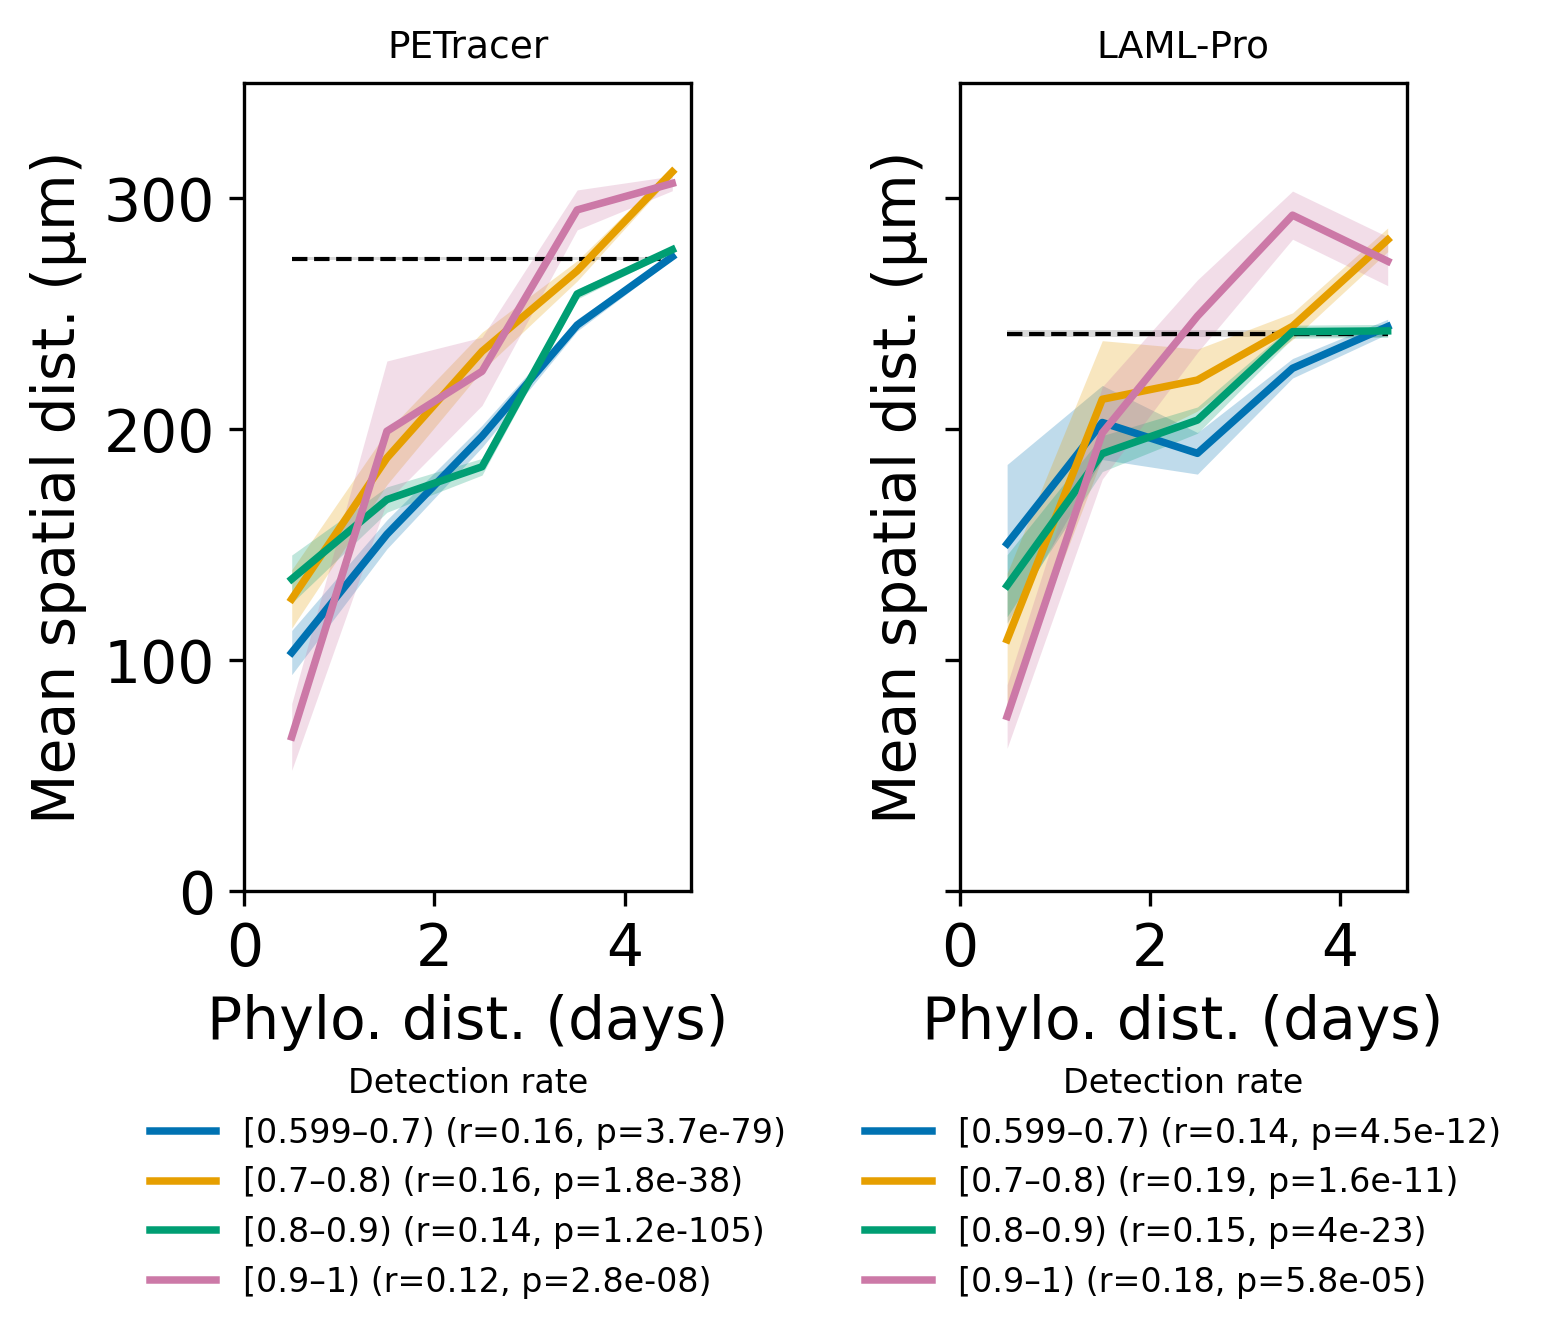

In [96]:

fig, corr = plot_correlation_linepanels(
    centroids_df, pet_distmat, lp_distmat=lp_distmat,
    detection_rate=meta_df['detection_rate'],
    dist_scale=0.5,
    detection_bin_edges=np.arange(0.6, 1.01, 0.1),
    pet_title="PETracer",
    lp_title="LAML-Pro",
    tree_bin_edges=np.arange(0, 6, 1),
    ylimit=(0, 350),
    figsize=(5.0, 3.5),
    outfile=f"{plotdir}/colonies_colony{colony}_exp2_spatial_vs_tree_linepanels.pdf"
)
print(corr["PET"])  # per-bin Pearson stats


In `PEtracer2025/colony_tracing/plot.py`, the function `spatial_distance_lineplot` generates the relevant plot in the paper. They stratify by detection rate, and plots mean spatial distance vs. binned tree distance with a "null" band. They subsample down to 20,000 pairs.

In [1739]:
print(corr["PET"])

  detection_bin  n_pairs  pearson_r        p_value
0   [0.599–0.7)    14358   0.156261   3.673043e-79
1     [0.7–0.8)     6613   0.158533   1.772859e-38
2     [0.8–0.9)    24095   0.139961  1.155382e-105
3       [0.9–1)     2242   0.116888   2.847124e-08


### create a new colony_h5ad with the lamlpro tree / hack to run the spatial correlation plotting code

In [84]:
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.subset.newick"
lp_tree = treeswift.read_tree_newick(lp_tree_fname)

branch_thresh = 0.0005
lp_tree.collapse_short_branches(branch_thresh)
lp_tree.scale_edges(6/lp_tree.height())
lp_tree.write_tree_newick(lp_tree_fname[:-7] + ".scaled6days.newick")

In [85]:
lp_tree_fname[:-7] + ".scaled6days.newick"

'/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.subset.scaled6days.newick'

In [86]:
output = subprocess.run(["python", "/Users/gc3045/git/laml2-experiments/real_data/analysis/helpers/newick_to_digraph_ete.py",
                         lp_tree_fname[:-7] + ".scaled6days.newick",
                         "-o", lp_tree_fname[:-7] + ".scaled6days.graphml"])

Root: internal_832
Nodes: 1305 | Edges: 1304
Leaves: 695 | Internal nodes: 610
Saved: /Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment2/outputs_petracer_colonies_clone3/fastlaml_colonies_clone3.neighbor_joining_tree.subset.scaled6days.graphml


In [87]:
lp_tree_digraph_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1/fastlaml_colonies_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.scaled6days.graphml"

In [88]:
lp_digraph = networkx.read_graphml(lp_tree_digraph_fname)

In [89]:
colony_pet_df.obst['3'] = lp_digraph

In [90]:
colony_pet_df.write_h5td("/Users/gc3045/git/laml2-experiments/real_data/analysis/colony_tracing_lamlpro_exp2.h5td")

#### branch length variance

In [1753]:
pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies_clone3.petracer.neighbor_joining.nwk'
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1/fastlaml_colonies_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.scaled6days.newick"

In [1754]:
lp_tree = treeswift.read_tree_newick(lp_tree_fname)
pet_tree = treeswift.read_tree_newick(pet_tree_fname)

In [1755]:
pet_tree_df = branch_table(pet_tree)
lp_tree_df = branch_table(lp_tree)

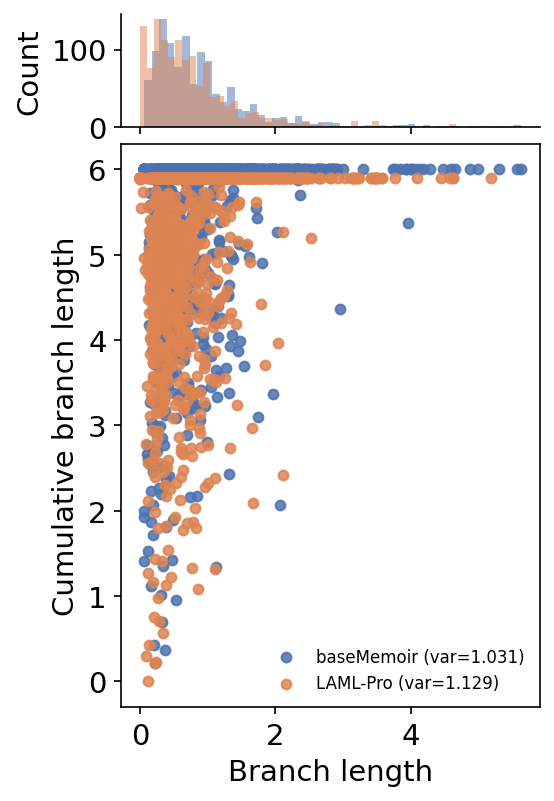

In [1756]:
_ = plot_bl_variance(pet_tree_df, lp_tree_df, title=None, 
                outfile=f"{plotdir}/colonies_colony{colony}_branchlen_variance.pdf")

#### 3D interactive plots

In [1548]:
lp_tree_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1/fastlaml_colonies_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_tree.scaled.newick"
pet_tree_fname = '/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/trees/colonies/clone3.petracer.neighbor_joining.scaled.newick'

In [1549]:
lp_tree = treeswift.read_tree_newick(lp_tree_fname)
pet_tree = treeswift.read_tree_newick(pet_tree_fname)

In [1550]:
analysis_basename = "/Users/gc3045/git/laml2-experiments/real_data/analysis"

In [1551]:
tau = 6

In [1570]:
centroids_df.columns = ['X', 'Y']

In [1571]:
pd.concat([lp_merged_df, centroids_df])

,X,Y
NaN,Dim_0,Dim_1
internal_695,-1926.2183241507169,-1329.9782108045697
internal_698,-1919.6924250185502,-1403.3759230436453
internal_699,-1925.5079252595553,-1321.949684457263
internal_701,-1924.9487068832038,-1328.4576064889382
...,...,...
colony-22494,-1809.638161,-1495.294858
colony-22497,-1794.031278,-1540.900003
colony-22501,-1780.506049,-1569.227952
colony-22504,-1787.151774,-1513.151003


In [1609]:
lp_ancestral_labeling = f"{analysis_basename}/colonies_clone3_exp1_lp_ancestral_labeling.txt"
pet_ancestral_labeling = f"{analysis_basename}/colonies_clone3_exp1_pet_ancestral_labeling.txt"

lp_merged_df = pd.read_csv(lp_ancestral_labeling, index_col=0)
lp_merged_df.columns = ['X', 'Y']
lp_merged_df = pd.concat([lp_merged_df, centroids_df])

pet_merged_df = pd.read_csv(pet_ancestral_labeling, index_col=0)
pet_merged_df.columns = ['X', 'Y']
pet_merged_df = pd.concat([pet_merged_df, centroids_df])


In [1579]:
fig = plot_tree_3d(
    lp_tree, lp_merged_df, x_col="X", y_col="Y",
    title="LAML-Pro: Cells in 3D",
    outfile=f"{plotdir}/colonies_clone{colony}_lamlpro_tree.html"
)

Saved interactive HTML to: /Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_clone3_lamlpro_tree.html


In [1610]:

fig = plot_tree_3d(
    pet_tree, pet_merged_df, x_col="X", y_col="Y",
    title="PETracer: Cells in 3D",
    outfile=f"{plotdir}/colonies_clone{colony}_petracer_tree.html"
)


Saved interactive HTML to: /Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_clone3_petracer_tree.html


### How many genotypes did we impute differently?

In [1757]:
lp_map_geno = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/runjobs/colonies_experiment1/fastlaml_colonies_fastlaml_colonies_clone3.petracer.neighbor_joining_tree.round2_posterior_argmax.csv"
pet_input_geno = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/colonies_clone3_petracer_genotypes.csv"

In [1758]:
inputs_basename = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"
lookup_codebook = pd.read_csv(inputs_basename + "/colonies_label_codebook.csv")
code_map = (lookup_codebook
            .copy())
code_map

,site,label,genotype
0,EMX1,unedited,0
1,EMX1,ACAAT,1
2,EMX1,AGTAC,2
3,EMX1,ATCAA,3
4,EMX1,ATTCG,4
5,EMX1,CCCTA,5
6,EMX1,CCGAT,6
7,EMX1,CCTTT,7
8,EMX1,GGACA,8
9,HEK3,unedited,0


In [1759]:
lp_map_geno_df = pd.read_csv(lp_map_geno, skiprows=2, index_col=0)
lp_map_geno_df = lp_map_geno_df.loc[
    ~lp_map_geno_df.index.astype(str).str.startswith('internal_')
]

pet_input_geno_df = pd.read_csv(pet_input_geno)


In [1760]:
np.mean(lp_map_geno_df.loc['colony-22252'] != lp_map_geno_df.loc['colony-22313'])

np.float64(0.0)

In [1761]:
np.mean((pet_genocall_df.loc['colony-22252'] != pet_genocall_df.loc['colony-22313']) & (pet_genocall_df.loc['colony-22252'] != -1) & ((pet_genocall_df.loc['colony-22313']) != -1) )

np.float64(0.020833333333333332)

In [1762]:
(pet_genocall_df.loc['colony-22252'] != pet_genocall_df.loc['colony-22313']) & (pet_genocall_df.loc['colony-22252'] != -1) & ((pet_genocall_df.loc['colony-22313']) != -1)

target_site
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41     True
42    False
43    False
44    False
45    False
46    False
47    False
dtype: bool

In [1763]:
pet_genocall_df.loc[['colony-22252', 'colony-22313']]

target_site,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
cell_name,,,,,,,,,,,,,,,,,,,,,
colony-22252,0,0,5,-1,-1,-1,0,1,0,0,...,-1,4,5,8,3,2,8,-1,-1,-1
colony-22313,0,0,5,5,5,5,0,1,0,0,...,0,4,5,2,-1,-1,-1,0,0,0


In [1831]:
pet_genocall_df

target_site,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
cell_name,,,,,,,,,,,,,,,,,,,,,
colony-21229,0,5,5,-1,-1,-1,8,0,0,0,...,3,4,0,2,3,2,8,0,0,0
colony-21230,4,0,5,-1,-1,-1,0,0,0,-1,...,5,4,0,2,3,2,8,0,0,0
colony-21240,8,0,5,-1,-1,-1,8,0,0,-1,...,3,4,0,8,3,2,8,0,0,0
colony-21241,4,0,5,-1,-1,-1,8,0,0,8,...,5,4,4,3,8,8,8,8,0,0
colony-21243,-1,-1,-1,5,0,5,8,3,0,8,...,1,4,0,3,0,8,8,8,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
colony-22494,0,2,5,5,4,5,0,0,0,3,...,-1,-1,-1,-1,8,5,8,0,0,5
colony-22497,0,2,5,5,4,5,-1,-1,-1,-1,...,5,-1,-1,-1,8,5,8,-1,-1,-1
colony-22501,4,0,5,-1,-1,-1,8,0,0,8,...,5,4,8,8,1,5,8,8,0,0


In [1833]:
num_duplicates = (pet_genocall_df.duplicated(keep=False)).sum()
num_duplicates

np.int64(0)

In [1839]:
adj.sum().sum()

np.int64(951)

In [1840]:
pet_genocall_df.shape

(695, 48)

In [1835]:
A = pet_genocall_df.to_numpy()
eq = (A[:, None, :] == A[None, :, :]) | (A[:, None, :] == -1) | (A[None, :, :] == -1)
adj = eq.all(axis=2)
n = adj.shape[0]
seen = np.zeros(n, bool)
labels = -np.ones(n, int)
cid = 0
for i in range(n):
    if not seen[i]:
        stack = [i]; seen[i] = True; labels[i] = cid
        while stack:
            v = stack.pop()
            nxt = np.where(adj[v] & ~seen)[0]
            if nxt.size:
                seen[nxt] = True
                labels[nxt] = cid
                stack.extend(nxt.tolist())
        cid += 1

# Counts per relaxed-duplicate group
unique_cids, sizes = np.unique(labels, return_counts=True)
print("Group sizes:", sizes)                            # size of each group
print("Num groups:", len(sizes))
print("Rows in duplicate groups:", sizes[sizes > 1].sum())
print("Num duplicate groups:", (sizes > 1).sum())


Group sizes: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  4  2  1  1  1  2  2  1  1  1
  1  1  1  2  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  7  1  1  1  2  2  1  1  1  1  1  1  1  2  1  1
  1  2  1  5  1  1  1  1  1  1  1  1  1  1  1  6  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  2  1  1  1  1  1  1  1  1
  1  1  1  1  1  2  1  1  2 16  1  1  1  1  2  1  2  4  1  3  1  1  2  3
  1  1  1  1  1  1  1  1  4  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  4  3  5  3
  1  1  1  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1  2  1  1  1  1  1
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  8  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  1
  1  1  1  2  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  1  1  1  1  1  1  1  

In [1764]:
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))
pet_distmat = distdict_to_df(pet_tree.distance_matrix(leaf_labels=True))

In [1765]:
lp_distmat['colony-22252']['colony-22313']

np.float64(2.237609934242238e-05)

In [1766]:
pet_distmat['colony-22252']['colony-22313']

np.float64(2.123891065035621)

In [1767]:
# 0. subset down to the same cells
mask = pet_input_geno_df['cellBC'].astype(str).isin(
    lp_map_geno_df_filtered.index.astype(str)
)
pet_input_geno_df = pet_input_geno_df.loc[mask].copy()
pet_input_geno_df['cellBC'].nunique(), lp_map_geno_df_filtered.index.nunique()

(695, 695)

In [1768]:
pet_cell_names = set(pet_input_geno_df['cellBC'])
lp_cell_names = set(lp_map_geno_df.index)

In [1769]:
lp_map_geno_df.columns = [int(col.split('_')[1]) for col in lp_map_geno_df.columns]

In [1770]:
pet_geno_df = pet_input_geno_df[['cellBC', 'target_idx', 'pet_geno', 'pet_prob']].rename(columns={'cellBC': 'cell_name', 
                                                                                      'target_idx': 'target_site',
                                                                                      'pet_geno': 'pet_geno'})
pet_genocall_df = pet_geno_df.pivot(index='cell_name', columns='target_site', values='pet_geno').sort_index(axis=1).fillna(-1).astype(int)

In [1771]:
lp_map_geno_df.shape, pet_genocall_df.shape

((695, 48), (695, 48))

In [1772]:
shared_sites = [c for c in pet_genocall_df.columns if c in lp_map_geno_df.columns]

In [1773]:
lp_long = lp_map_geno_df[shared_sites].stack().reset_index()
lp_long.columns = ["cell_name", "target_site", "lp_state"]

In [1774]:
# bm_long = pet_genocall_df[shared_sites].stack().reset_index()
# bm_long.columns = ["cell_name", "target_site", "pub_geno"]

In [1775]:
# 1. merge pet_input_geno_df with lp_map_geno_df_filtered based on cell_name and target_idx
merged = pet_geno_df.merge(lp_long, on=['cell_name', 'target_site'])

In [1776]:
merged = merged.rename(columns={'pet_geno': 'pub_geno',
                                'pet_prob': 'pub_pmax'})

In [1777]:
summary_path = f"{plotdir}/colonies_colony{colony}_merged_summary.csv"
merged.to_csv(summary_path)

In [1778]:
output = subprocess.run(["Rscript", "/Users/gc3045/git/laml2-experiments/real_data/r_plotting/plot_genotypecall_summary.R",
                         "--path", summary_path,
                         "--othermethod", "PETracer",
                         "--outfile", f"{plotdir}/colonies_colony{colony}_genotypecall_summary.pdf"])
print("Genotype summary path printed to", f"{plotdir}/colonies_colony{colony}_genotypecall_summary.pdf")

New names:
• `` -> `...1`
Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.
Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.


Genotype summary path printed to /Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_colony3_genotypecall_summary.pdf


✅ Saved: /Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_colony3_genotypecall_summary.pdf


In [1779]:
filt_pet_geno = pet_input_geno_df[['cellBC', 'pet_geno', 'pet_prob', 'target_idx','kde_geno']].rename(columns={'cellBC': 'cell_name',
                                                                                                               'target_idx': 'target_site',
                                                                                                               'pet_geno': 'bM_geno',
                                                                                                               'pet_prob': 'bM_pmax'})

In [1780]:
summary_df = build_summary_df(filt_pet_geno, lp_map_geno_df)

[build_summary_df] merged rows: 26568 | LP matches: 26568 | both_present: 26568 | agree: 26003 (0.9787338151159289) | disagree_true: 565 (0.021266184884071063)


In [1781]:
695 * 48, 26568/(695 * 48)

(33360, 0.7964028776978417)

In [1782]:
# plot_genotype_confidence(summary_df, title=f"Colony {colony}: PETracer probabilities\nLAML-Pro vs baseMemoir genotypes",
#                          outfile=f"{plotdir}/colonies_clone{colony}_genotype_probabilities.pdf",bins=100)

Num categories: [-1  0  1  2  3  4  5  6  7  8]


/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



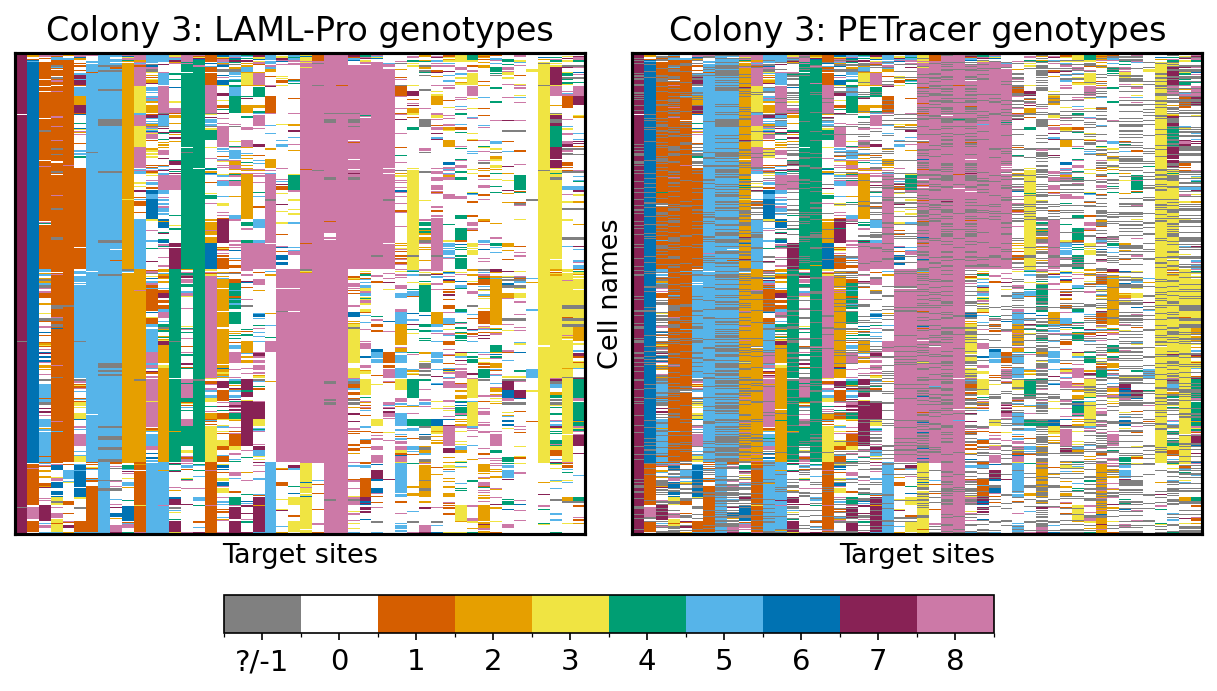

In [1783]:
fig = clustermap_genos(pet_genocall_df, lp_map_geno_df, metric='hamming', method='single', title=f"Colony {colony}", other="PETracer", vmin=-1, vmax=8, show_cell_names=False,
                 outfile=f"{plotdir}/colonies_colony{colony}_genotype_comparison.pdf")

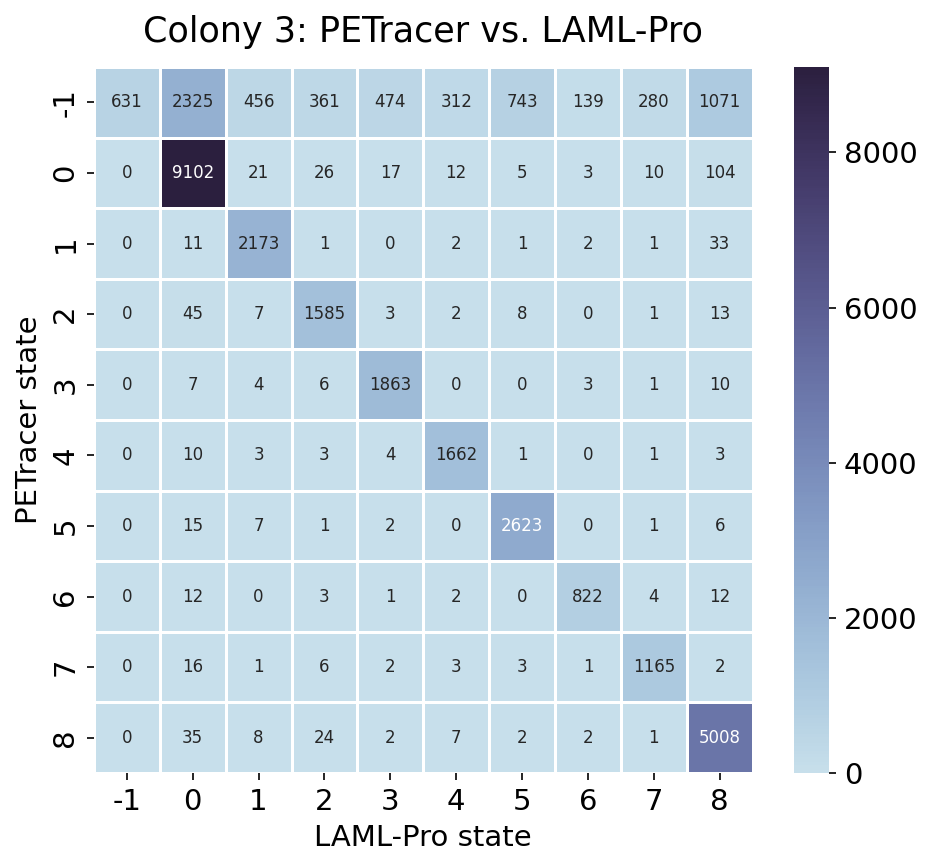

In [1784]:
counts = plot_state_counts(pet_genocall_df, lp_map_geno_df, title=f"Colony {colony}: PETracer vs. LAML-Pro", ylabel="PETracer state", 
                           outfile=f"{plotdir}/colonies_colony{colony}_genotype_counts.pdf", use_state_labels=False)

In [1785]:
states = ['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8']
# states=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [1786]:
counts.index = [str(x) for x in counts.index]
counts.columns = [str(x) for x in counts.columns]

In [1787]:
stats_df = report_genotype_call_stats(counts, states=states, other_method="PETracer")
stats_df

,Missing/\nSilenced,0,1,2,3,4,5,6,7,8,Total
PETracer,0.2036,0.2788,0.0667,0.0499,0.0568,0.0506,0.0796,0.0257,0.0359,0.1525,1.0000
LAML-Pro (obs) prop. over all sites,0.0000,0.2774,0.0667,0.0496,0.0568,0.0507,0.0792,0.0250,0.0355,0.1556,0.7964
LAML-Pro (impute) prop. over all sites,0.0189,0.0697,0.0137,0.0108,0.0142,0.0094,0.0223,0.0042,0.0084,0.0321,0.2036
LAML-Pro (obs) prop. over observed sites,NaN,0.3483,0.0837,0.0623,0.0713,0.0636,0.0995,0.0314,0.0446,0.1954,1.0000
LAML-Pro (impute) prop. over missing sites,0.0929,0.3423,0.0671,0.0532,0.0698,0.0459,0.1094,0.0205,0.0412,0.1577,1.0000


In [1788]:
t1 = stats_df.loc[['PETracer', 'LAML-Pro (obs) prop. over all sites']].rename(columns={"Missing/\nSilenced":"?/-1"})
t1

,?/-1,0,1,2,3,4,5,6,7,8,Total
PETracer,0.2036,0.2788,0.0667,0.0499,0.0568,0.0506,0.0796,0.0257,0.0359,0.1525,1.0000
LAML-Pro (obs) prop. over all sites,0.0000,0.2774,0.0667,0.0496,0.0568,0.0507,0.0792,0.0250,0.0355,0.1556,0.7964


In [1789]:
t2= stats_df.loc[['LAML-Pro (obs) prop. over observed sites', 'LAML-Pro (impute) prop. over missing sites']].rename(columns={"Missing/\nSilenced":"?/-1"})
t2

,?/-1,0,1,2,3,4,5,6,7,8,Total
LAML-Pro (obs) prop. over observed sites,NaN,0.3483,0.0837,0.0623,0.0713,0.0636,0.0995,0.0314,0.0446,0.1954,1.0
LAML-Pro (impute) prop. over missing sites,0.0929,0.3423,0.0671,0.0532,0.0698,0.0459,0.1094,0.0205,0.0412,0.1577,1.0


In [1790]:
save_df_to_pdf(t1, filename=f"{plotdir}/colonies_colony{colony}_genotype_call_stats_t1.pdf", title=None, floatfmt="{:.4f}",fontsize=16)
save_df_to_pdf(t2, filename=f"{plotdir}/colonies_colony{colony}_genotype_call_stats_t2.pdf", title=None, floatfmt="{:.4f}",fontsize=16)

/Users/gc3045/git/laml2-experiments/real_data/analysis/helpers/utils.py:697: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/Users/gc3045/git/laml2-experiments/real_data/analysis/helpers/utils.py:697: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



'/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/colonies_colony3_genotype_call_stats_t2.pdf'